# Advanced Regression Assignment - House Price Prediction

# Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
<ul>
<li>Which variables are significant in predicting the price of a house.</li>
<li>How well those variables describe the price of a house.</li>
</ul>

# Business Goal

We are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Step 1: Reading and Understanding the Data

In [1]:
# Supress Warnings and import all required packages

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime as dt
pd.set_option("display.max_rows", 85)
pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.preprocessing import PowerTransformer
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import os

In [2]:
house_df = pd.read_csv("train (1).csv")

In [3]:
# Check the head of the dataset
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Calculate Age from all the Year Columns
now = dt.datetime.now()
house_df['BuiltAge'] = (now.year - house_df['YearBuilt']).astype('int')
house_df['RemodelAge'] = (now.year - house_df['YearRemodAdd']).astype('int')
house_df['GarageAge'] = (now.year - house_df['GarageYrBlt']).fillna(-1).astype('int') #Imputing garage age as -1 if a building does not has any garage 
house_df['BuildingSoldAge'] = (now.year - house_df['YrSold']).astype('int')

# Drop actual columns form the dataframe
house_df.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'], inplace=True)

#### Inspect the various aspects of the house_df dataframe

In [5]:
#Print Shape of the DataFrame
house_df.shape

(1460, 81)

## Step 2: Missing Value Analysis and Imputation

In [6]:
# Check for missing value
colum_with_missing_value = ((house_df.isnull().sum() * 100) / len(house_df.index)).to_frame().reset_index()
colum_with_missing_value.columns = ['ColumnName', 'MissingValuePrec']
colum_with_missing_value['MissingValuePrec'] = colum_with_missing_value['MissingValuePrec'].apply(lambda x: round(x, 2))
colum_with_missing_value.loc[colum_with_missing_value.MissingValuePrec > 0]

,ColumnName,MissingValuePrec
3,LotFrontage,17.74
6,Alley,93.77
23,MasVnrType,0.55
24,MasVnrArea,0.55
28,BsmtQual,2.53
29,BsmtCond,2.53
30,BsmtExposure,2.60
31,BsmtFinType1,2.53
33,BsmtFinType2,2.60
40,Electrical,0.07


#### Although we have significant number of missing values for some columns but those should not be deleted for below reason
<ul>
<li>Missing value in Alley columns means `No Alley Access` to the house</li>
<li>Missing value in FireplaceQu columns means `No Fireplace` in the house</li>
<li>Missing value in PoolQC columns means `No Pool` in the house</li>
<li>Missing value in Fence columns means `No Fence` in the house</li>
<li>Missing value in MiscFeature columns means `No Miscellaneous feature` in the house</li>
</ul>

In [7]:
#Lets Impute the column accordingly
house_df['Alley'] = house_df['Alley'].fillna('No Alley Access')
house_df['FireplaceQu'] = house_df['FireplaceQu'].fillna('No Fireplace')
house_df['PoolQC'] = house_df['PoolQC'].fillna('No Pool')
house_df['Fence'] = house_df['Fence'].fillna('No Fence')
house_df['MiscFeature'] = house_df['MiscFeature'].fillna('No Miscellaneous Feature')

We have meaningful missing values for column `LotFrontage`
as missing values in this column represents `No Street Connected to the Property`

We have meaningful missing values for columns `MasVnrType`, `MasVnrArea`
as missing values in these column represents `No Masonry Veneer Area` available in the house

We have meaningful missing values for columns `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`
as missing values in these column represents `No Basement`available in the house

We have meaningful missing values for columns `Electrical`
as missing values in this column represents `No Electrical System` available in the house

We have meaningful missing values for columns `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`
as missing values in these column represents `No Garage` available in the house

In [8]:
#Lets Impute the column accordingly
house_df['Alley'] = house_df['Alley'].fillna('No Alley Access')
house_df['LotFrontage'] = house_df['LotFrontage'].fillna(0)
house_df['MasVnrType'] = house_df['MasVnrType'].fillna('No Masonry Veneer')
house_df['MasVnrArea'] = house_df['MasVnrArea'].fillna(0)
house_df['BsmtQual'] = house_df['BsmtQual'].fillna('No Basement')
house_df['BsmtCond'] = house_df['BsmtCond'].fillna('No Basement')
house_df['BsmtExposure'] = house_df['BsmtExposure'].fillna('No Basement')
house_df['BsmtFinType1'] = house_df['BsmtFinType1'].fillna('No Basement')
house_df['BsmtFinType2'] = house_df['BsmtFinType2'].fillna('No Basement')
house_df['Electrical'] = house_df['Electrical'].fillna('No Electrical System')

house_df['GarageType'] = house_df['GarageType'].fillna('No Garage')
house_df['GarageFinish'] = house_df['GarageFinish'].fillna('No Garage')
house_df['GarageQual'] = house_df['GarageQual'].fillna('No Garage')
house_df['GarageCond'] = house_df['GarageCond'].fillna('No Garage')

In [9]:
# Droping insignificant columns
house_df.drop(columns=['Id'], inplace=True)

In [10]:
# Check for missing value
colum_with_missing_value = ((house_df.isnull().sum() * 100) / len(house_df.index)).to_frame().reset_index()
colum_with_missing_value.columns = ['ColumnName', 'MissingValuePrec']
colum_with_missing_value['MissingValuePrec'] = colum_with_missing_value['MissingValuePrec'].apply(lambda x: round(x, 2))
colum_with_missing_value

,ColumnName,MissingValuePrec
0,MSSubClass,0.0
1,MSZoning,0.0
2,LotFrontage,0.0
3,LotArea,0.0
4,Street,0.0
5,Alley,0.0
6,LotShape,0.0
7,LandContour,0.0
8,Utilities,0.0
9,LotConfig,0.0


#### Now we dont have any missing values in any of the columns

In [11]:
# Print Information of the dataframe
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       1460 non-null   int64  
 1   MSZoning         1460 non-null   object 
 2   LotFrontage      1460 non-null   float64
 3   LotArea          1460 non-null   int64  
 4   Street           1460 non-null   object 
 5   Alley            1460 non-null   object 
 6   LotShape         1460 non-null   object 
 7   LandContour      1460 non-null   object 
 8   Utilities        1460 non-null   object 
 9   LotConfig        1460 non-null   object 
 10  LandSlope        1460 non-null   object 
 11  Neighborhood     1460 non-null   object 
 12  Condition1       1460 non-null   object 
 13  Condition2       1460 non-null   object 
 14  BldgType         1460 non-null   object 
 15  HouseStyle       1460 non-null   object 
 16  OverallQual      1460 non-null   int64  
 17  OverallCond   

**Datatypes of all the columns are appropriate**

In [12]:
# Print Desciption of the dataframe
house_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,BuiltAge,RemodelAge,GarageAge,BuildingSoldAge
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,6.099315,5.575342,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890,48.732192,35.134247,39.136301,12.184247
std,42.300571,34.664304,9981.264932,1.382997,1.112799,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883,30.202904,20.645407,25.892617,1.328095
min,20.000000,0.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,10.000000,10.000000,-1.000000,10.000000
25%,20.000000,42.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000,20.000000,16.000000,17.000000,11.000000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000,47.000000,26.000000,35.500000,12.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000,66.000000,53.000000,58.000000,13.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000,148.000000,70.000000,120.000000,14.000000


## Step 3: Data Visualization and EDA

#### Univariate Analysis for Categorical Variables

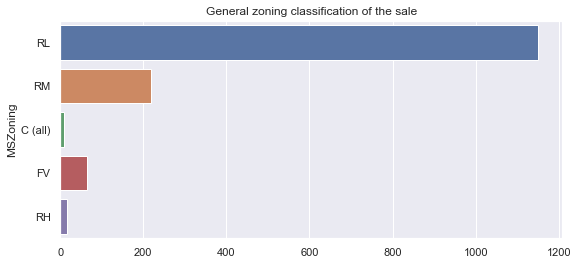

In [13]:
plt.figure(figsize=(9, 4))
sns.set(style="darkgrid")
plt.title('General zoning classification of the sale')
ax = sns.countplot(y='MSZoning', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `MSZoning` variable <br>
MSZoning: Identifies the general zoning classification of the sale.
<ul>
    <li>A - Agriculture</li>
    <li>C - Commercial</li>
    <li>FV - Floating Village Residential</li>
    <li>I - Industrial</li>
    <li>RH - Residential High Density</li>
    <li>RL - Residential Low Density</li>
    <li>RP - Residential Low Density Park</li> 
    <li>RM - Residential Medium Density</li>
</ul>

**Most of the properties are available in Residential Low Density Area**

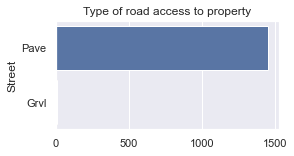

In [14]:
plt.figure(figsize=(4,2))
sns.set(style="darkgrid")
plt.title('Type of road access to property')
ax = sns.countplot(y='Street', data=house_df)
ax.set_xlabel('')

plt.show()

From the above count plot we can see almost all the house is having `Paved steet`. Also we can identfy this column is highly imbalnced. Than is why our model will not be able to learn anithing form this column.

In [15]:
#Check teh value count
house_df.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [16]:
# Lets drop the column as more than 99% values belong to only one category.
house_df.drop(columns=['Street'], inplace=True)

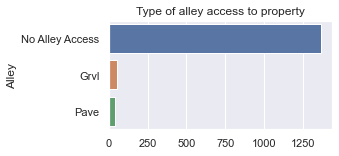

In [17]:
plt.figure(figsize=(4,2))
sns.set(style="darkgrid")
plt.title('Type of alley access to property')
ax = sns.countplot(y='Alley', data=house_df)
ax.set_xlabel('')

plt.show()

From the above count plot we can see maximum is having `No Ally Access`.

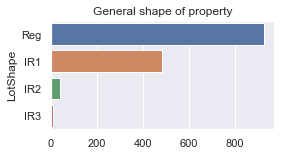

In [18]:
plt.figure(figsize=(4,2))
sns.set(style="darkgrid")
plt.title('General shape of property')
ax = sns.countplot(y='LotShape', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `LotShape` variable <br>
LotShape: General shape of property
<ul>
    <li>Reg - Regular</li>
    <li>IR1 - Slightly irregular</li>
    <li>IR2 - Moderately Irregular</li>
    <li>IR3 - Irregular</li>
</ul>

From the above count plot we can see maximum house is having shape as `eigher Regualar or Slightly Irregular`

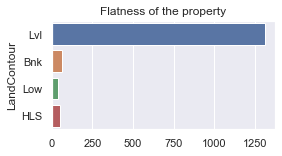

In [19]:
plt.figure(figsize=(4,2))
sns.set(style="darkgrid")
plt.title('Flatness of the property')
ax = sns.countplot(y='LandContour', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `LandContour` variable <br>
LandContour: Flatness of the property
<ul>
    <li>Lvl - Near Flat/Level	</li>
    <li>Bnk - Banked, Quick and significant rise from street grade to building</li>
    <li>HLS - Hillside, Significant slope from side to side</li>
    <li>Low - Depression</li>
</ul>

Maximum perperty are build on Flat or near flat surface

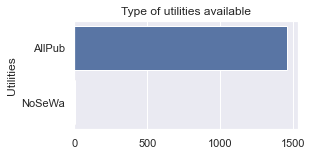

In [20]:
plt.figure(figsize=(4,2))
sns.set(style="darkgrid")
plt.title('Type of utilities available')
ax = sns.countplot(y='Utilities', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `Utilities` variable <br>
Utilities: Type of utilities available
<ul>
    <li>AllPub - All public Utilities (E,G,W,& S)</li>
    <li>NoSewr - Electricity, Gas, and Water (Septic Tank)</li>
    <li>NoSeWa - Electricity and Gas Only</li>
    <li>ELO - Electricity only</li>
</ul>

From the above count plot we can see almost all the house is having `All public Utilities`. Also we can identfy this column is highly imbalnced. Than is why our model will not be able to learn anithing form this column.

In [21]:
#Check teh value count
house_df.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [22]:
# Lets drop the column as more than 99% values belong to only one category.
house_df.drop(columns=['Utilities'], inplace=True)

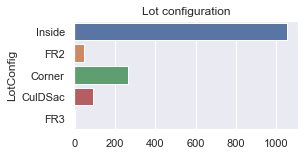

In [23]:
plt.figure(figsize=(4,2))
sns.set(style="darkgrid")
plt.title('Lot configuration')
ax = sns.countplot(y='LotConfig', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `LotConfig` variable <br>
LotConfig: Lot configuration
<ul>
    <li>Inside - Inside lot</li>
    <li>Corner - Corner lot</li>
    <li>CulDSac - Cul-de-sac</li>
    <li>FR2 - Frontage on 2 sides of property</li>
    <li>FR3 - Frontage on 3 sides of property</li>
</ul>

maximum building are having lot inside of it

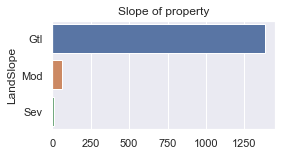

In [24]:
plt.figure(figsize=(4,2))
sns.set(style="darkgrid")
plt.title('Slope of property')
ax = sns.countplot(y='LandSlope', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `LandSlope` variable <br>
LandSlope: Slope of property
<ul>
    <li>Gtl - Gentle slope</li>
    <li>Mod - Moderate Slope</li>
    <li>Sev - Severe Slope</li>
</ul>

Maximum property are having Gentle Slop

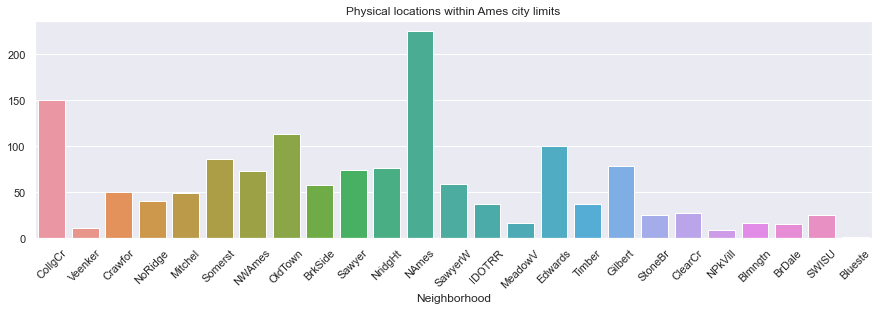

In [25]:
plt.figure(figsize=(15, 4))
sns.set(style="darkgrid")
plt.title('Physical locations within Ames city limits')
ax = sns.countplot(x='Neighborhood', data=house_df)
ax.set_ylabel('')
plt.xticks(rotation=45)

plt.show()

Maximum buildings are situated in either `North Ames` or `College Creek` area

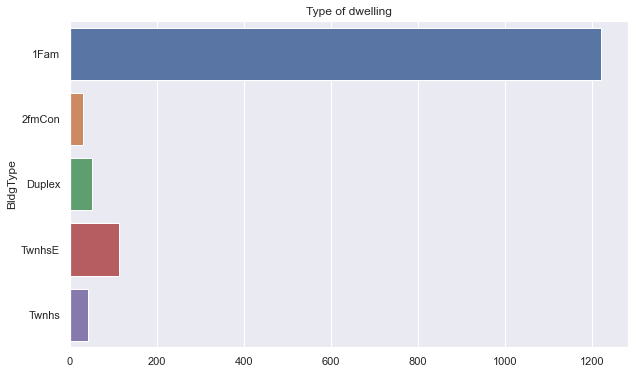

In [26]:
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
plt.title('Type of dwelling')
ax = sns.countplot(y='BldgType', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `BldgType` variable <br>
BldgType: Type of dwelling
<ul>
    <li>Fam - Single, family Detached</li>
    <li>FmCon - Two family Conversion; originally built as one family dwelling</li>
    <li>Duplx - Duplex</li>
    <li>TwnhsE - Townhouse End Unit</li>
    <li>TwnhsI - Townhouse Inside Unit</li>
</ul>

maximum building are of type `Single, family Detached`

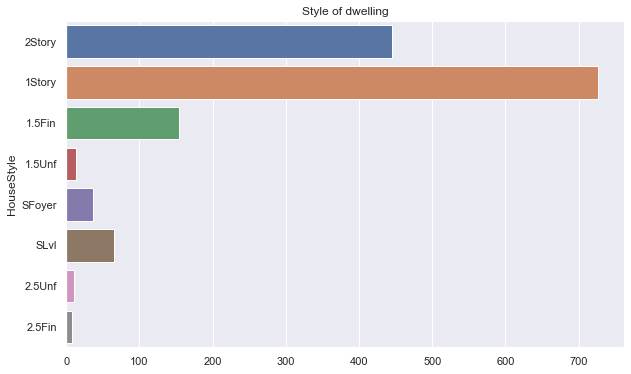

In [27]:
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
plt.title('Style of dwelling')
ax = sns.countplot(y='HouseStyle', data=house_df)
ax.set_xlabel('')

plt.show()

Interpretation of `HouseStyle` variable <br>
HouseStyle: Style of dwelling
<ul>
    <li>1Story - One story</li>
    <li>1.5Fin - One and one-half story: 2nd level finished</li>
    <li>1.5Unf - One and one-half story: 2nd level unfinished</li>
    <li>2Story - Two story</li>
    <li>2.5Fin - Two and one-half story: 2nd level finished</li>
    <li>2.5Unf - Two and one-half story: 2nd level unfinished</li>
    <li>SFoyer - Split Foyer</li>
    <li>SLvl - Split Level</li>
</ul>

Maximum building are of style either 1 Story or 2 Story

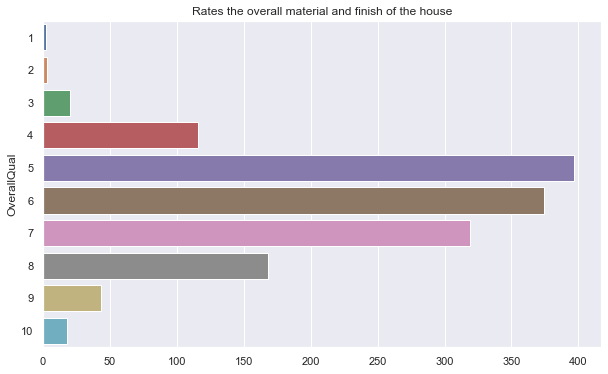

In [28]:
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
plt.title('Rates the overall material and finish of the house')
ax = sns.countplot(y='OverallQual', data=house_df)
ax.set_xlabel('')

plt.show()

Overall Quality of the house are eithre `Average` or `Above Average` or `Good` or `Very Good`

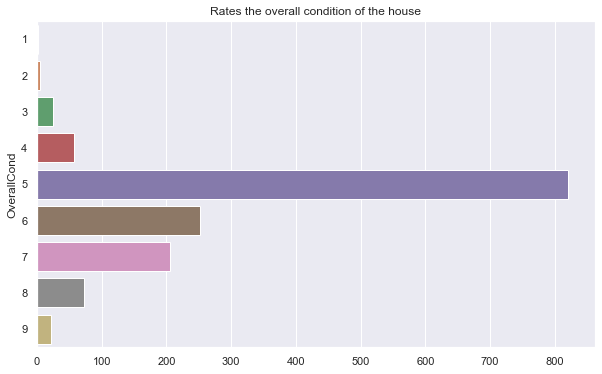

In [29]:
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
plt.title('Rates the overall condition of the house')
ax = sns.countplot(y='OverallCond', data=house_df)
ax.set_xlabel('')

plt.show()

Maximum houses are having over all condition as `Average`

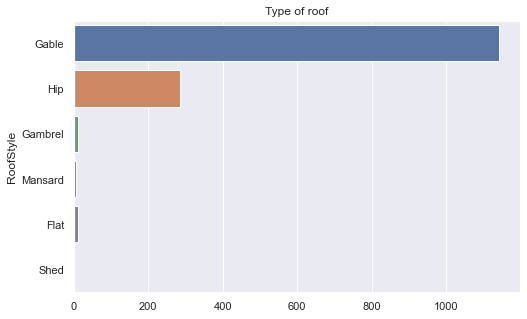

In [30]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
plt.title('Type of roof')
ax = sns.countplot(y='RoofStyle', data=house_df)
ax.set_xlabel('')

plt.show()

Maximum roof of the building is made of `Gable`

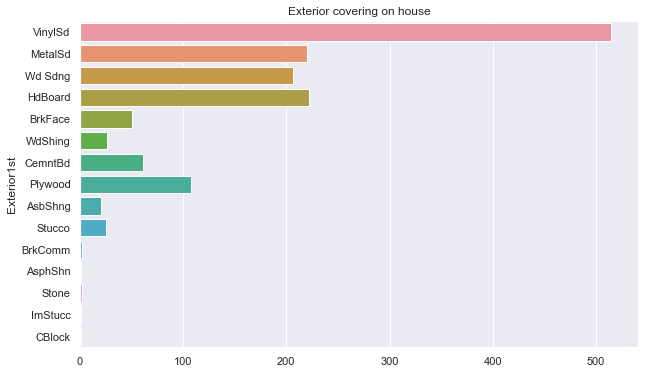

In [31]:
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
plt.title('Exterior covering on house')
ax = sns.countplot(y='Exterior1st', data=house_df)
ax.set_xlabel('')

plt.show()

Exterior coverung on maximum house is of `Vinyl Siding`

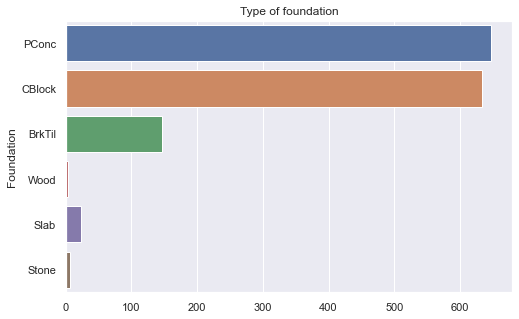

In [32]:
plt.figure(figsize=(8,5))
sns.set(style="darkgrid")
plt.title('Type of foundation')
ax = sns.countplot(y='Foundation', data=house_df)
ax.set_xlabel('')

plt.show()

Foundation of maximum house is made of either `Poured Contrete` or `Cinder Block`

#### Univariate Analysis for Numeric Variables

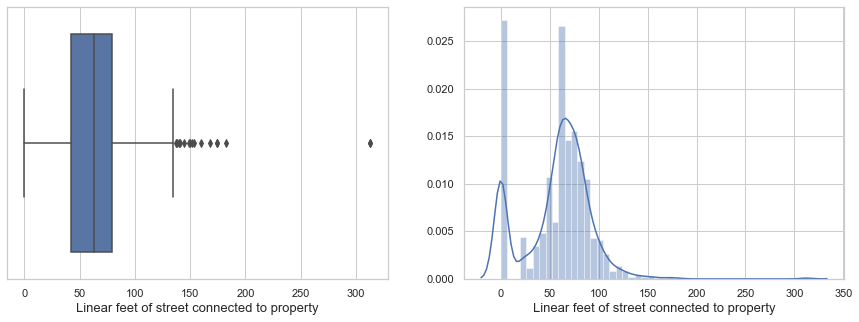

In [33]:
# Plot Box Plot and Distribution Plot
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
ax = sns.boxplot(house_df['LotFrontage'])
ax.set_xlabel('Linear feet of street connected to property', size=13)

plt.subplot(1,2,2)
ax = sns.distplot(house_df['LotFrontage'])
ax.set_xlabel('Linear feet of street connected to property', size=13)

plt.show()

Msximum data distribution of `LotFrontage` variable is between 40 to 70

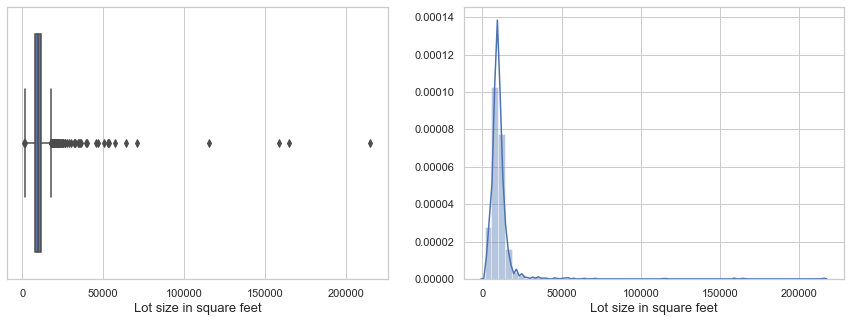

In [34]:
# Plot Box Plot and Distribution Plot
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
ax = sns.boxplot(house_df['LotArea'])
ax.set_xlabel('Lot size in square feet', size=13)

plt.subplot(1,2,2)
ax = sns.distplot(house_df['LotArea'])
ax.set_xlabel('Lot size in square feet', size=13)

plt.show()

Maximum Distribution between 0 to 25000

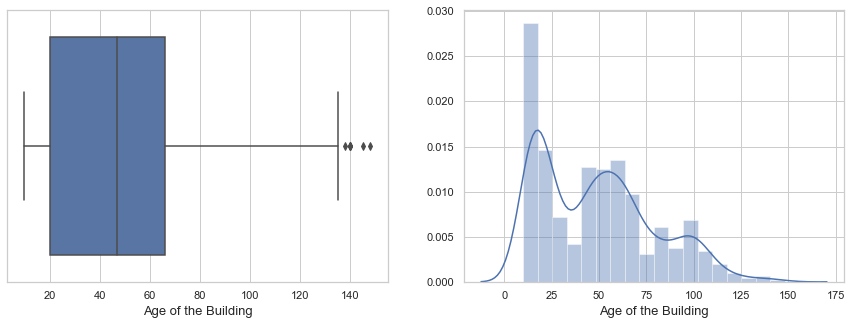

In [35]:
# Plot Box Plot and Distribution Plot
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
ax = sns.boxplot(house_df['BuiltAge'])
ax.set_xlabel('Age of the Building', size=13)

plt.subplot(1,2,2)
ax = sns.distplot(house_df['BuiltAge'])
ax.set_xlabel('Age of the Building', size=13)

plt.show()

Maximum building is having age between 20 to 70

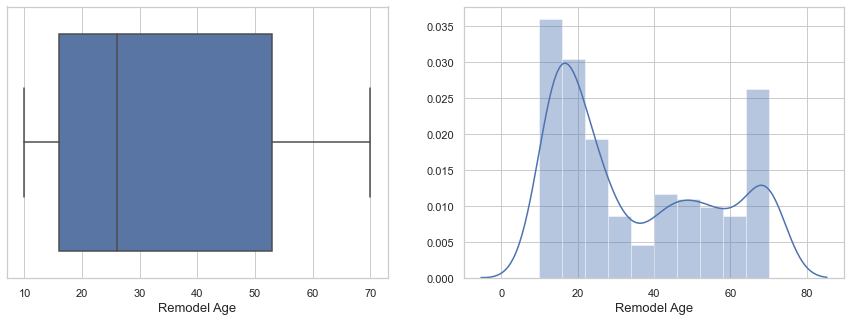

In [36]:
# Plot Box Plot and Distribution Plot
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
ax = sns.boxplot(house_df['RemodelAge'])
ax.set_xlabel('Remodel Age', size=13)

plt.subplot(1,2,2)
ax = sns.distplot(house_df['RemodelAge'])
ax.set_xlabel('Remodel Age', size=13)

plt.show()

Remodel age of maximum number of house are between 15 to 55

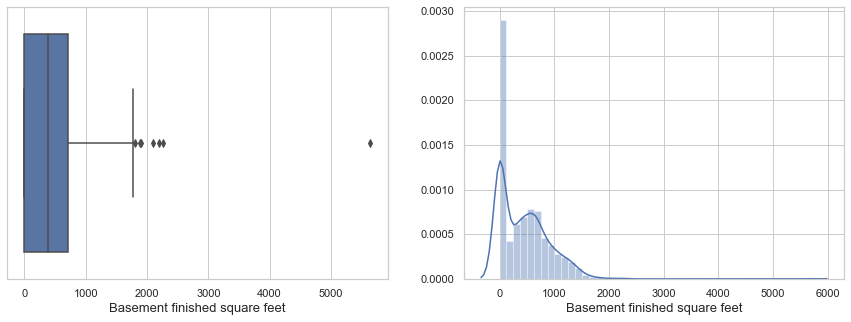

In [37]:
# Plot Box Plot and Distribution Plot
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
ax = sns.boxplot(house_df['BsmtFinSF1'])
ax.set_xlabel('Basement finished square feet', size=13)

plt.subplot(1,2,2)
ax = sns.distplot(house_df['BsmtFinSF1'])
ax.set_xlabel('Basement finished square feet', size=13)

plt.show()

Maximum building is having Basement finish area between 0 to 800

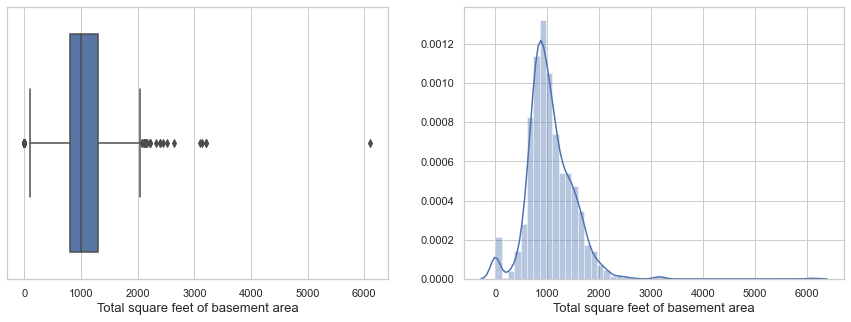

In [38]:
# Plot Box Plot and Distribution Plot
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
ax = sns.boxplot(house_df['TotalBsmtSF'])
ax.set_xlabel('Total square feet of basement area', size=13)

plt.subplot(1,2,2)
ax = sns.distplot(house_df['TotalBsmtSF'])
ax.set_xlabel('Total square feet of basement area', size=13)

plt.show()

median is 1000 for Total basement square feet

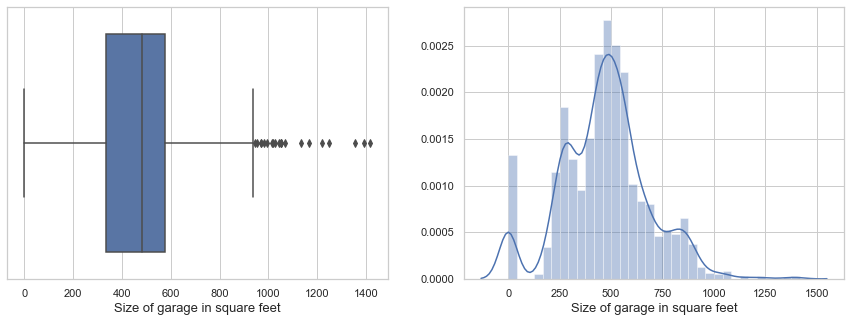

In [39]:
# Plot Box Plot and Distribution Plot
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
ax = sns.boxplot(house_df['GarageArea'])
ax.set_xlabel('Size of garage in square feet', size=13)

plt.subplot(1,2,2)
ax = sns.distplot(house_df['GarageArea'])
ax.set_xlabel('Size of garage in square feet', size=13)

plt.show()

maximum distribution of the data is around 500.

#### Bivariate Analysis - Numeric vs Numeric

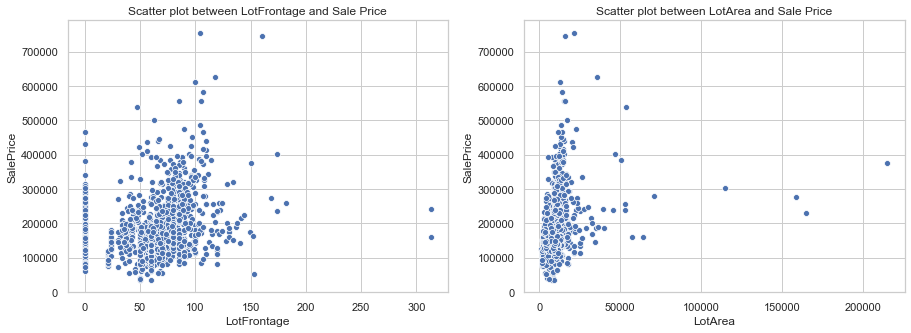

In [40]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
plt.title('Scatter plot between LotFrontage and Sale Price')
sns.scatterplot(x = 'LotFrontage', y = 'SalePrice', data=house_df)

plt.subplot(1,2,2)
plt.title('Scatter plot between LotArea and Sale Price')
sns.scatterplot(x = 'LotArea', y = 'SalePrice', data=house_df)

plt.show()

Data Distribution is random. no pattern is visible.

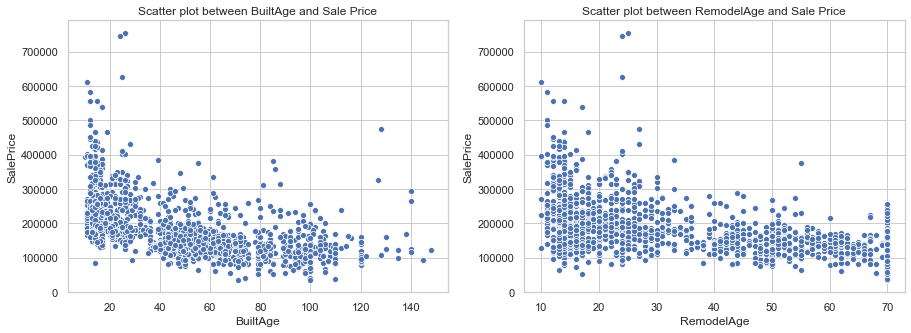

In [41]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
plt.title('Scatter plot between BuiltAge and Sale Price')
sns.scatterplot(x = 'BuiltAge', y = 'SalePrice', data=house_df)

plt.subplot(1,2,2)
plt.title('Scatter plot between RemodelAge and Sale Price')
sns.scatterplot(x = 'RemodelAge', y = 'SalePrice', data=house_df)

plt.show()

Price is high for building having less Built Age or Remodel Age

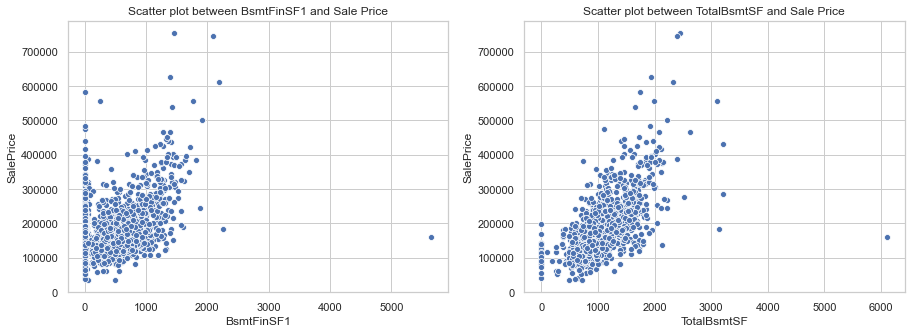

In [42]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
plt.title('Scatter plot between BsmtFinSF1 and Sale Price')
sns.scatterplot(x = 'BsmtFinSF1', y = 'SalePrice', data=house_df)

plt.subplot(1,2,2)
plt.title('Scatter plot between TotalBsmtSF and Sale Price')
sns.scatterplot(x = 'TotalBsmtSF', y = 'SalePrice', data=house_df)

plt.show()

Price is high for building having more square feet of finished basement or more square feet of total basement

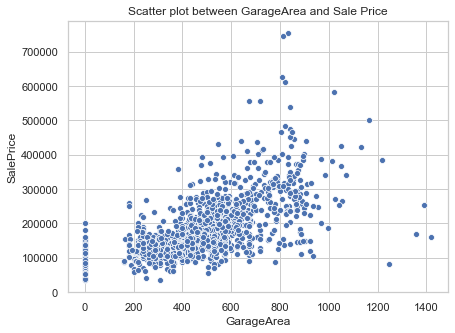

In [43]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')

plt.subplot(1,2,1)
plt.title('Scatter plot between GarageArea and Sale Price')
sns.scatterplot(x = 'GarageArea', y = 'SalePrice', data=house_df)

plt.show()

Price is high for house having more Garage Area

#### Multivariate Analysis

Heatmap

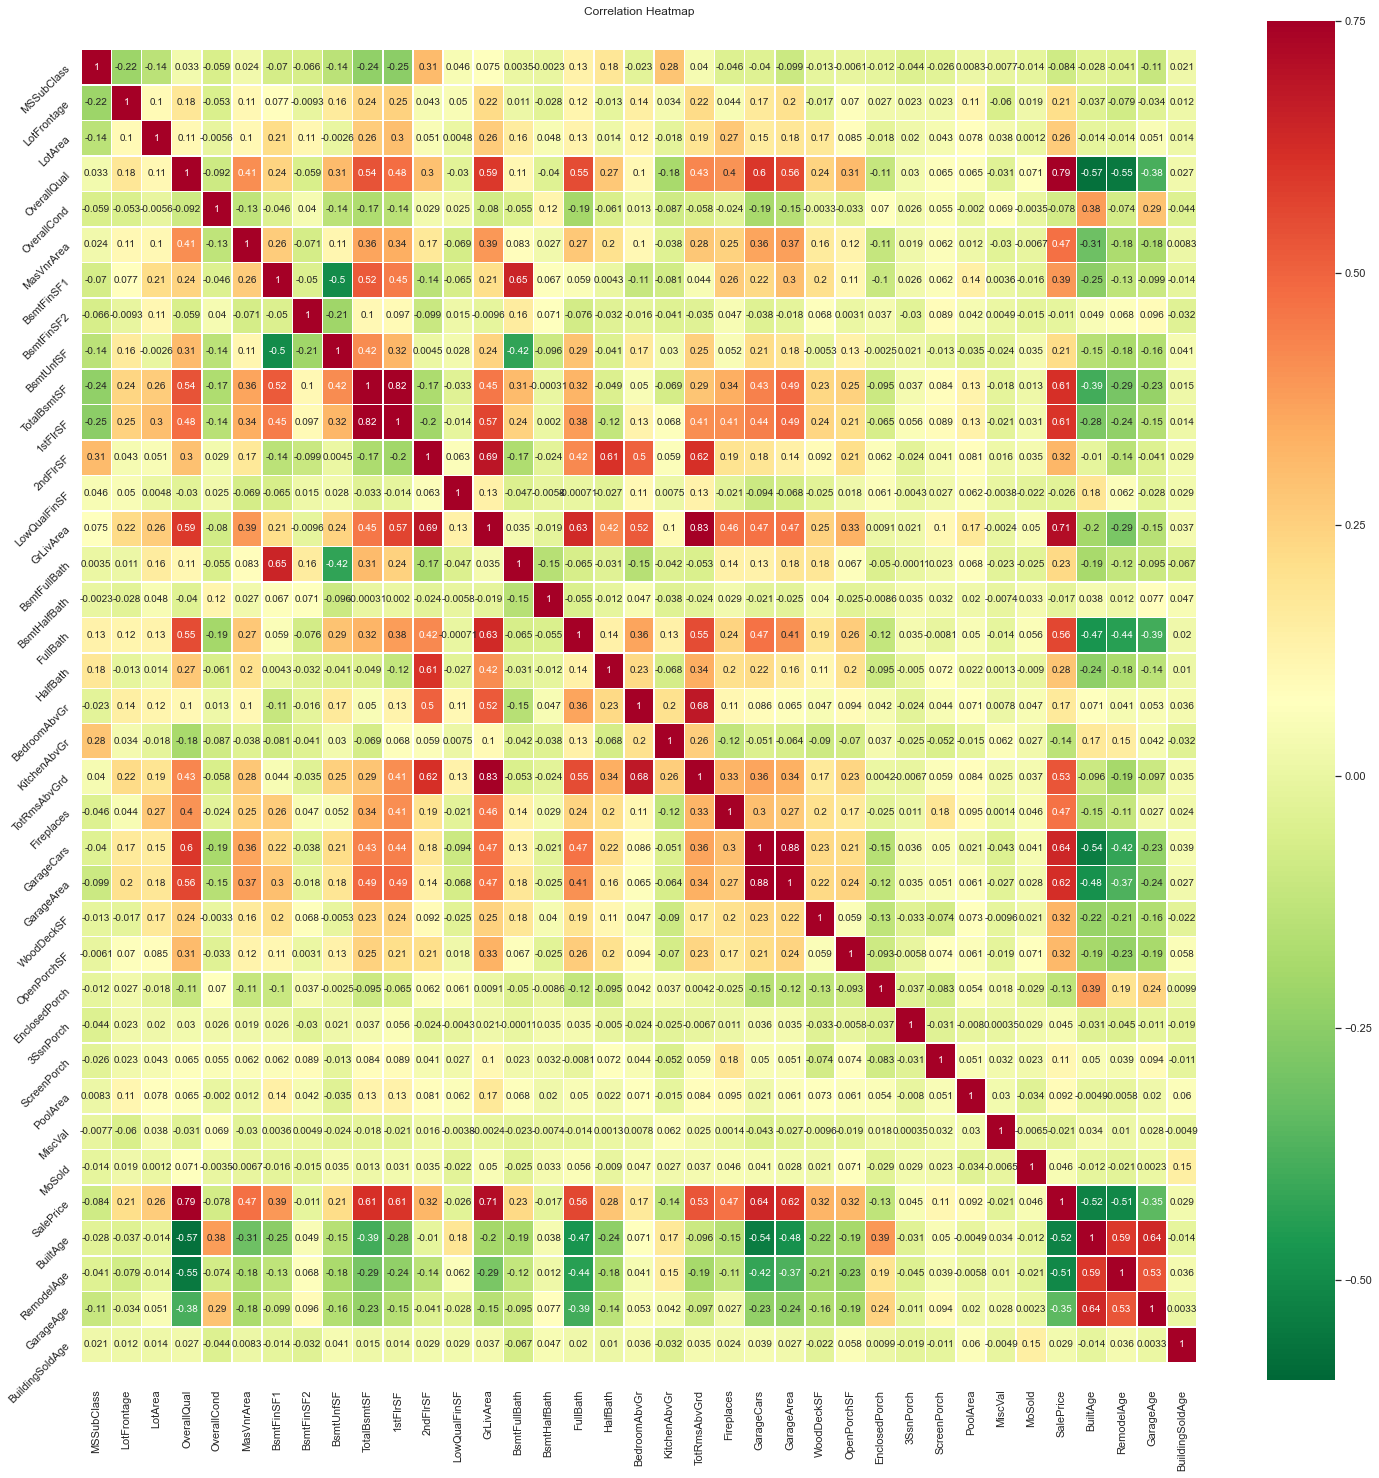

In [44]:
plt.figure(figsize=(25, 25))
corr=house_df.corr()
ax=sns.heatmap(corr, cmap=plt.cm.RdYlGn_r, vmin = -0.6, annot = True, vmax = 0.75, linewidths=.5, annot_kws={"size": 10})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation Heatmap');

### Step 4: Data Preparation for Modeling

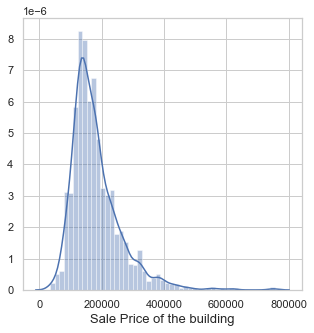

In [45]:
#### Check distribution of target variable
plt.figure(figsize=(5,5))
sns.set_style('whitegrid')

ax = sns.distplot(house_df['SalePrice'])
ax.set_xlabel('Sale Price of the building', size=13)

plt.show()

#### Distribution of Sales Price column is right skewed. so we need to convet it to a normal distribution.

In [46]:
pt = PowerTransformer()
house_df['SalePrice'] = pt.fit_transform(pd.DataFrame(house_df['SalePrice']))

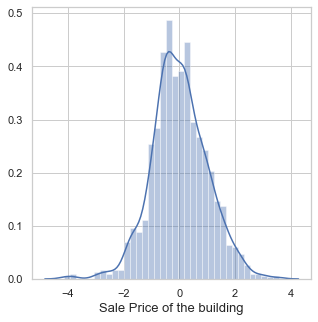

In [47]:
#### Check distribution of target variable
plt.figure(figsize=(5, 5))
sns.set_style('whitegrid')

ax = sns.distplot(house_df['SalePrice'])
ax.set_xlabel('Sale Price of the building', size=13)

plt.show()

#### Using Power transformation dependant variable is converted into fairly normal distribution

In [48]:
# split into X and y
y = house_df.pop('SalePrice')
X = house_df
print(X.shape)
print(y.shape)

(1460, 77)
(1460,)


In [49]:
# creating dummy variables for categorical variables

# subset all categorical variables
house_categorical = X.select_dtypes(include=['object'])
house_categorical.head()


,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,No Alley Access,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,No Fireplace,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No Miscellaneous Feature,WD,Normal
1,RL,No Alley Access,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No Miscellaneous Feature,WD,Normal
2,RL,No Alley Access,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No Miscellaneous Feature,WD,Normal
3,RL,No Alley Access,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,No Pool,No Fence,No Miscellaneous Feature,WD,Abnorml
4,RL,No Alley Access,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,No Pool,No Fence,No Miscellaneous Feature,WD,Normal


In [50]:
# convert into dummies
house_dummies = pd.get_dummies(house_categorical, drop_first=True)
house_dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_No Alley Access,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,...,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No Pool,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No Fence,MiscFeature_No Miscellaneous Feature,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [51]:
# drop categorical variables 
X = X.drop(list(house_categorical.columns), axis=1)

In [52]:
# concat dummy variables with X
X = pd.concat([X, house_dummies], axis=1)

In [53]:
X.shape

(1460, 259)

### Step 5: Feature Scaling of Train Set

In [54]:
# scaling the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=259)

### Step 6: Split dataset into Test set and Train set

In [55]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

### Step 7: Model Building and Evaluation

#### Feature selection using RFE

In [57]:
linreg = LinearRegression()
rfe = RFE(linreg, 50)             # running RFE with 50 variables as output
rfe = rfe.fit(X_train, y_train)

In [58]:
rfe_columns = X_train.columns[rfe.support_]

In [59]:
rfe_columns

Index(['OverallQual', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageCars', 'BuiltAge', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Condition2_PosN', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_AsphShn', 'Exterior1st_CBlock', 'Exterior2nd_AsphShn',
       'Exterior2nd_CBlock', 'Exterior2nd_Other', 'BsmtQual_No Basement',
       'BsmtCond_No Basement', 'BsmtFinType1_No Basement',
       'BsmtFinType2_No Basement', 'Electrical_No Electrical System',
       'GarageType_No Garage', 'GarageFinish_No Garage', 'GarageQual_Fa',
       'GarageQual_Gd', 'GarageQual_No Garage', 'GarageQual_Po',
       'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_No Garage', 'GarageCond_Po', 'GarageCond_TA', 'PoolQC_Gd',
       'PoolQC_No Pool', '

## Ridge Regression

In [60]:
# list of alphas to tune
params = {'alpha': [10, 500, 1000, 1500, 1600, 1700]}

ridge = Ridge()

# cross validation
folds = 5
model_cv_ridge = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv_ridge.fit(X_train[rfe_columns], y_train) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [10, 500, 1000, 1500, 1600, 1700]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [61]:
cv_results_ridge = pd.DataFrame(model_cv_ridge.cv_results_)
cv_results_ridge

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.056401,0.101809,0.002200,9.761184e-04,10,{'alpha': 10},-0.235397,-0.275688,-0.253736,-0.228933,-0.229094,-0.244561,0.017996,1,-0.219815,-0.221979,-0.221833,-0.223739,-0.222796,-0.222032,0.001300
1,0.003798,0.000398,0.001402,4.912856e-04,500,{'alpha': 500},-0.262898,-0.304629,-0.293501,-0.265976,-0.274276,-0.280239,0.016190,2,-0.269995,-0.258456,-0.264837,-0.269586,-0.271427,-0.266860,0.004751
2,0.002999,0.000632,0.001000,6.289914e-07,1000,{'alpha': 1000},-0.310161,-0.350772,-0.335575,-0.309532,-0.325118,-0.326216,0.015671,3,-0.318289,-0.304262,-0.313564,-0.318364,-0.321352,-0.315166,0.005995
3,0.003201,0.000400,0.001599,4.885597e-04,1500,{'alpha': 1500},-0.351229,-0.388162,-0.368064,-0.343702,-0.368624,-0.363944,0.015469,4,-0.356451,-0.343081,-0.353603,-0.357801,-0.360255,-0.354238,0.005978
4,0.003201,0.000750,0.001001,1.567047e-06,1600,{'alpha': 1600},-0.358299,-0.394779,-0.373626,-0.349917,-0.376057,-0.370524,0.015506,5,-0.363259,-0.350086,-0.360719,-0.364729,-0.367087,-0.361176,0.005918
5,0.003200,0.000400,0.001000,1.152329e-06,1700,{'alpha': 1700},-0.365073,-0.401189,-0.379022,-0.356083,-0.383259,-0.376914,0.015541,6,-0.369810,-0.356794,-0.367518,-0.371393,-0.373616,-0.367826,0.005865


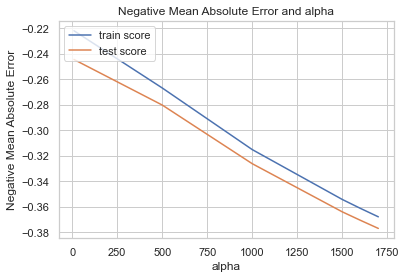

In [62]:
###### plotting mean test and train scoes with alpha 
cv_results_ridge['param_alpha'] = cv_results_ridge['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_train_score'])
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

#### Lets consider alpha as 1200 and reduild the model using Ridge

In [63]:
alpha = 1200 * 2

ridge = Ridge(alpha=alpha)

ridge.fit(X_train[rfe_columns], y_train)

Ridge(alpha=2400, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [64]:
train_r2_score = r2_score(y_train, ridge.predict(X_train[rfe_columns]))
print('R2 in train set -> {0}'.format(train_r2_score, 2))

R2 in train set -> 0.7224222171537789


In [65]:
test_r2_score = r2_score(y_test, ridge.predict(X_test[rfe_columns]))
print('R2 in test set -> {0}'.format(test_r2_score, 2))

R2 in test set -> 0.7153857679694803


In [66]:
ridge_coefficient = pd.DataFrame() 
ridge_coefficient['Columns'] = X_train[rfe_columns].columns 
ridge_coefficient['Coefficient'] = pd.Series(ridge.coef_) 
ridge_coefficient['ABS_Coefficient'] = pd.Series(ridge.coef_) .apply(lambda x:abs(x))
ridge_coefficient.sort_values(by=['ABS_Coefficient'], ascending=False, inplace=True)
ridge_coefficient[['Columns', 'Coefficient']].head()

,Columns,Coefficient
0,OverallQual,0.132255
9,GrLivArea,0.110268
10,GarageCars,0.087387
11,BuiltAge,-0.086547
6,1stFlrSF,0.081217


## Lasso Regression

In [67]:
# list of alphas to tune
params = {'alpha': [0.01, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.15]}

lasso = Lasso()

# cross validation
model_cv_lasso = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_lasso.fit(X_train[rfe_columns], y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075,
                                   0.08, 0.085, 0.09, 0.095, 0.1, 0.15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [68]:
cv_results_lasso = pd.DataFrame(model_cv_lasso.cv_results_)
cv_results_lasso.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.059796,0.094056,0.000997,0.000006,0.01,{'alpha': 0.01},-0.225368,-0.275601,-0.254487,-0.229341,-0.233526,-0.243647,0.018866,1,-0.227241,-0.226052,-0.225901,-0.226762,-0.227045,-0.226600,0.000534
1,0.003602,0.000491,0.000999,0.000001,0.05,{'alpha': 0.05},-0.233833,-0.289016,-0.267242,-0.251456,-0.260699,-0.260423,0.018185,2,-0.256760,-0.240262,-0.248264,-0.252900,-0.252177,-0.250073,0.005597
2,0.003593,0.000484,0.000800,0.000400,0.055,{'alpha': 0.055},-0.237277,-0.291741,-0.270636,-0.256879,-0.264846,-0.264249,0.017781,3,-0.261899,-0.243547,-0.252260,-0.258495,-0.257232,-0.254687,0.006371
3,0.003802,0.000401,0.001400,0.000490,0.06,{'alpha': 0.06},-0.240952,-0.293799,-0.274859,-0.263122,-0.269424,-0.268404,0.017155,4,-0.267327,-0.246722,-0.256796,-0.264233,-0.262948,-0.259605,0.007295
4,0.002801,0.000747,0.000999,0.000632,0.065,{'alpha': 0.065},-0.245189,-0.296536,-0.279489,-0.269765,-0.274478,-0.273064,0.016641,5,-0.273155,-0.250170,-0.261874,-0.270096,-0.269011,-0.264861,0.008224


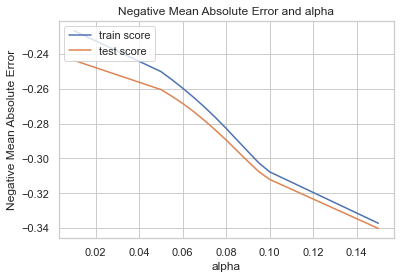

In [69]:
# plotting mean test and train scoes with alpha 
cv_results_lasso['param_alpha'] = cv_results_lasso['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_train_score'])
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

#### Lets consider alpha as 0.075 and reduild the model using Ridge

In [70]:
alpha = 0.075

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train[rfe_columns], y_train) 

Lasso(alpha=0.075, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [71]:
train_r2_score = r2_score(y_train, lasso.predict(X_train[rfe_columns]))
print('R2 in train set -> {0}'.format(train_r2_score))

R2 in train set -> 0.8268426431737821


In [72]:
test_r2_score = r2_score(y_test, lasso.predict(X_test[rfe_columns]))
print('R2 in test set -> {0}'.format(test_r2_score))

R2 in test set -> 0.8145929668037902


In [73]:
lasso.coef_

array([ 0.35718884,  0.03700579,  0.03181754,  0.        , -0.        ,
        0.07350201,  0.02501218,  0.        , -0.        ,  0.25068449,
        0.13112696, -0.14332891,  0.        , -0.        ,  0.02951213,
       -0.03264592, -0.01509455,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.05694389,  0.        ,  0.        ,  0.        ])

In [74]:
lasso_coefficient = pd.DataFrame() 
lasso_coefficient['Columns'] = X_train[rfe_columns].columns 
lasso_coefficient['Coefficient'] = pd.Series(lasso.coef_) 
lasso_coefficient['ABS_Coefficient'] = pd.Series(lasso.coef_).apply(lambda x:abs(x))
lasso_coefficient.sort_values(by=['ABS_Coefficient'], ascending=False, inplace=True)
lasso_coefficient[['Columns', 'Coefficient']].loc[lasso_coefficient['Coefficient'] != 0]

,Columns,Coefficient
0,OverallQual,0.357189
9,GrLivArea,0.250684
11,BuiltAge,-0.143329
10,GarageCars,0.131127
5,TotalBsmtSF,0.073502
46,PoolQC_Gd,-0.056944
1,OverallCond,0.037006
15,MSZoning_RM,-0.032646
2,BsmtFinSF1,0.031818
14,MSZoning_RL,0.029512


## Model Selection between Ridge and Lasso

**Ridge Model scores:**
<ul>
    <li> 0.815249359507</li>
    <li> 0.788944739067</li>
</ul>

**Lasso Model scores:**
<ul>
    <li> 0.829694233962</li>
    <li> 0.812560181348</li>
</ul>

**From the above score we can see Lasso is more stable model as difference between train and test score is less and lasso is using less number of predictor variables**

Now, Lets try to answer following businees problem using Lasso Model.

<ul>
    <li>Which variables are significant in predicting the price of a house</li>
    <li>How well those variables describe the price of a house</li>
</ul>

Below variables are significant in predicting the price of house
<ul>
    <li>OverallQual - Rates the overall material and finish of the house</li>
    <li>GrLivArea - Above grade (ground) living area square feet</li>
    <li>GarageCars - Size of garage in car capacity</li>
    <li>RemodelAge - Remodel Age</li>
    <li>BuiltAge - Building built Age</li>
    <li>TotalBsmtSF - Total square feet of basement area</li>
    <li>PoolQC_Gd - Pool quality - Good</li>
    <li>MSZoning_RL - Identifies the general zoning classification of the sale - Residential Low Density</li>
    <li>BsmtFinSF1 - Type 1 finished square feet</li>
    <li>MSZoning_RM - Identifies the general zoning classification of the sale - Residential Medium Density</li>
    <li>1stFlrSF - First Floor square feet</li>
    <li>Condition2_PosN - Proximity to various conditions - Near positive off-site feature</li>
    <li>OverallCond - Rates the overall condition of the house</li>
</ul>

**Using above variable we can predict House Price around 80% accurately**

## Code to answer Assignment Question

### Question 1

In [75]:
alpha = 1200 * 2
ridge = Ridge(alpha=alpha)
ridge.fit(X_train[rfe_columns], y_train)

train_r2_score = r2_score(y_train, ridge.predict(X_train[rfe_columns]))
print('R2 in train set -> {0}'.format(train_r2_score, 2))

test_r2_score = r2_score(y_test, ridge.predict(X_test[rfe_columns]))
print('R2 in test set -> {0}'.format(test_r2_score, 2))

R2 in train set -> 0.7224222171537789
R2 in test set -> 0.7153857679694803


In [76]:
alpha = 0.075 * 2
lasso = Lasso(alpha=alpha)
lasso.fit(X_train[rfe_columns], y_train)

train_r2_score = r2_score(y_train, lasso.predict(X_train[rfe_columns]))
print('R2 in train set -> {0}'.format(train_r2_score))

test_r2_score = r2_score(y_test, lasso.predict(X_test[rfe_columns]))
print('R2 in test set -> {0}'.format(test_r2_score))

R2 in train set -> 0.7634981624479714
R2 in test set -> 0.7675447052627818


### Question 3

In [77]:
list_of_columns = list(lasso_coefficient.sort_values(by=['ABS_Coefficient'], ascending=True)['Columns'].head(45))

In [78]:
# list of alphas to tune
params = {'alpha': [0.01, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.15]}

lasso = Lasso()

# cross validation
model_cv_lasso_qstn3 = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_lasso_qstn3.fit(X_train[list_of_columns], y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075,
                                   0.08, 0.085, 0.09, 0.095, 0.1, 0.15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [79]:
cv_results_lasso_qstn3 = pd.DataFrame(model_cv_lasso_qstn3.cv_results_)
cv_results_lasso_qstn3.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005195,0.000761,0.001000,6.650810e-06,0.01,{'alpha': 0.01},-0.352153,-0.393717,-0.361768,-0.339573,-0.345781,-0.358592,0.019024,1,-0.332598,-0.334663,-0.334564,-0.335523,-0.335656,-0.334601,0.001094
1,0.004207,0.000396,0.001593,4.857696e-04,0.05,{'alpha': 0.05},-0.375375,-0.420691,-0.397407,-0.391338,-0.398146,-0.396570,0.014579,2,-0.383459,-0.368922,-0.382159,-0.384017,-0.386760,-0.381063,0.006253
2,0.004805,0.001161,0.001402,4.763826e-04,0.055,{'alpha': 0.055},-0.381158,-0.423628,-0.400754,-0.398112,-0.407342,-0.402178,0.013772,3,-0.390436,-0.374714,-0.387554,-0.390230,-0.393672,-0.387321,0.006595
3,0.002600,0.000491,0.000800,4.000676e-04,0.06,{'alpha': 0.06},-0.386270,-0.426823,-0.404192,-0.404629,-0.416127,-0.407587,0.013557,4,-0.397568,-0.379949,-0.393336,-0.396504,-0.400445,-0.393560,0.007176
4,0.002600,0.000490,0.001000,7.294206e-07,0.065,{'alpha': 0.065},-0.391348,-0.430239,-0.408255,-0.410336,-0.423332,-0.412681,0.013441,5,-0.404587,-0.385639,-0.399473,-0.402793,-0.406241,-0.399747,0.007403


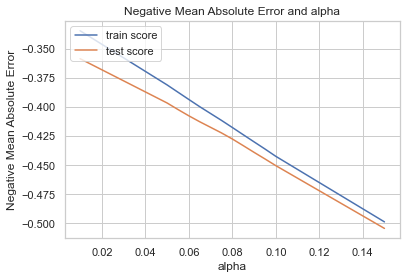

In [80]:
# plotting mean test and train scoes with alpha 
cv_results_lasso_qstn3['param_alpha'] = cv_results_lasso_qstn3['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results_lasso_qstn3['param_alpha'], cv_results_lasso_qstn3['mean_train_score'])
plt.plot(cv_results_lasso_qstn3['param_alpha'], cv_results_lasso_qstn3['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [81]:
#Consider alpha as 0.1 and build the model
alpha = 0.1
lasso_qstn3 = Lasso(alpha=alpha)
lasso_qstn3.fit(X_train[list_of_columns], y_train) 
lasso_qstn3.coef_

array([-5.26508111e-02,  8.00193286e-02,  0.00000000e+00, -5.67812927e-03,
       -0.00000000e+00, -1.24576804e-16,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  2.96048307e-01, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        1.85656677e-02,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        1.16858064e-01, -0.00000000e+00, -0.00000000e+00,  4.56711435e-01,
        0.00000000e+00,  4.54649604e-02, -9.50213039e-02,  0.00000000e+00,
       -4.15166527e-02])

In [82]:
train_r2_score = r2_score(y_train, lasso_qstn3.predict(X_train[list_of_columns]))
print('R2 in train set -> {0}'.format(train_r2_score))

test_r2_score = r2_score(y_test, lasso_qstn3.predict(X_test[list_of_columns]))
print('R2 in test set -> {0}'.format(test_r2_score))

R2 in train set -> 0.6293111940886349
R2 in test set -> 0.6449015350160876


In [83]:
lasso_coefficient_qstn3 = pd.DataFrame() 
lasso_coefficient_qstn3['Columns'] = X_train[list_of_columns].columns 
lasso_coefficient_qstn3['Coefficient'] = pd.Series(lasso_qstn3.coef_) 
lasso_coefficient_qstn3['ABS_Coefficient'] = pd.Series(lasso_qstn3.coef_).apply(lambda x:abs(x))
lasso_coefficient_qstn3.sort_values(by=['ABS_Coefficient'], ascending=False, inplace=True)
lasso_coefficient_qstn3[['Columns', 'Coefficient']].loc[lasso_coefficient_qstn3['Coefficient'] != 0]

,Columns,Coefficient
39,1stFlrSF,4.567114e-01
9,2ndFlrSF,2.960483e-01
36,GarageCond_TA,1.168581e-01
42,MSZoning_RM,-9.502130e-02
1,SaleType_New,8.001933e-02
0,BsmtCond_No Basement,-5.265081e-02
41,BsmtFinSF1,4.546496e-02
44,PoolQC_Gd,-4.151665e-02
28,GarageQual_TA,1.856567e-02
3,BsmtFinType1_No Basement,-5.678129e-03
